<img src="tmva_logo.gif" height="20%" width="20%">


# Regression Example

Example of TMVA for Regression

### Create Factory class

Create a factory class for the regression. It is important to specify that the AnalysisType is in this case **Regression**

In [1]:
TMVA::Tools::Instance();

auto inputFile = TFile::Open("inputdata_regression.root");
auto outputFile = TFile::Open("TMVA_RegressionOutput.root", "RECREATE");

TMVA::Factory factory("TMVARegression", outputFile,
                      "!V:!Silent:Color:!DrawProgressBar:AnalysisType=Regression" ); 

### Create DataLoader class

Cretae the DataLoader class and define the input features and the target for the regression.

In [2]:
TMVA::DataLoader loader("dataset"); 

// Add the feature variables, names reference branches in inputFile ttree
loader.AddVariable("var1");
loader.AddVariable("var2");
loader.AddVariable("var3");
loader.AddVariable("var4");
loader.AddVariable("var5 := var1-var3"); // create new features
loader.AddVariable("var6 := var1+var2");

loader.AddTarget( "target := var2+var3" ); // define the target for the regression


### Setup Dataset
Link dataloader to dataset and prepare the data

In [3]:
TTree *tree;
inputFile->GetObject("Sig", tree);

TCut mycuts = ""; // e.g. TCut mycuts = "abs(var1)<0.5";

loader.AddRegressionTree(tree, 1.0);   // link the TTree to the loader, weight for each event  = 1
loader.PrepareTrainingAndTestTree(mycuts,
                                   "nTrain_Regression=1000:nTest_Regression=1000:SplitMode=Random:NormMode=NumEvents:!V" );

DataSetInfo              : [dataset] : Added class "Regression"
                         : Add Tree Sig of type Regression with 6000 events
                         : Dataset[dataset] : Class index : 0  name : Regression


## Book the regression method

Book the method for regression. Here we choose the Boosted Decision Tree model. You have to use gradient boosted trees for regression, hence the BDTG and BoostType=Grad. 

Define the hyperparameters: ntrees, boosttype, shrinkage, and the depth. Also define the loss function you want to use: 'AbsoluteDeviation', 'Huber', or 'LeastSquares'. nCuts determines how finely to look at each feature. Larger values take more time, but you may get more accurate results.

In [4]:
// Boosted Decision Trees 
factory.BookMethod(&loader,TMVA::Types::kBDT, "BDTG_HU",
                   TString("!H:!V:NTrees=64::BoostType=Grad:Shrinkage=0.3:nCuts=20:MaxDepth=4:")+
                   TString("RegressionLossFunctionBDTG=Huber"));

Factory                  : Booking method: BDTG_HU
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Regression -- training events            : 1000
                         : Regression -- testing events             : 1000
                         : Regression -- training and testing events: 2000
                         : 
DataSetInfo              : Correlation matrix (Regression):
                         : --------------------------------------------------------------
                         :               var1    var2    var

In [5]:
// Boosted Decision Trees 
factory.BookMethod(&loader,TMVA::Types::kBDT, "BDTG_LS",
                   TString("!H:!V:NTrees=64::BoostType=Grad:Shrinkage=0.3:nCuts=20:MaxDepth=4:")+
                   TString("RegressionLossFunctionBDTG=LeastSquares"));

Factory                  : Booking method: BDTG_LS
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray


# Train Method

In [6]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:    0.19981    0.99823   [    -2.8842     3.3534 ]
              

# Test and Evaluate the Model

In [7]:
factory.TestAllMethods();    

Factory                  : Test all methods
Factory                  : Test method: BDTG_HU for Regression performance
                         : 
                         : Dataset[dataset] : Create results for testing
                         : Dataset[dataset] : Evaluation of BDTG_HU on testing sample
                         : Dataset[dataset] : Elapsed time for evaluation of 1000 events: 0.0056 sec       
                         : Create variable histograms
                         : Create regression target histograms
                         : Create regression average deviation
                         : Results created
Factory                  : Test method: BDTG_LS for Regression performance
                         : 
                         : Dataset[dataset] : Create results for testing
                         : Dataset[dataset] : Evaluation of BDTG_LS on testing sample
                         : Dataset[dataset] : Elapsed time for evaluation of 1000 events: 0.00464 sec

In [8]:
factory.EvaluateAllMethods();

Factory                  : Evaluate all methods
                         : Evaluate regression method: BDTG_HU
                         : TestRegression (testing)
                         : Calculate regression for all events
                         : Elapsed time for evaluation of 1000 events: 0.00464 sec       
                         : TestRegression (training)
                         : Calculate regression for all events
                         : Elapsed time for evaluation of 1000 events: 0.00449 sec       
TFHandler_BDTG_HU        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:    0.23094    0.99817   [    -2.8856     3.0447 ]
                         :     var2:    0.31764     1.0242   [    -3.1385     3.9137 ]
                         :     var3:    0.37240     1.0031   [    -3.1826     3.4690 ]
                         :     var4:    0.8

## Gather and Plot the Results
Let's plot the residuals for the BDTG predictions. First, close the output file so that it saves to disk and we can open it without issue. Then get the results on the test set. Finally, plot the residuals.

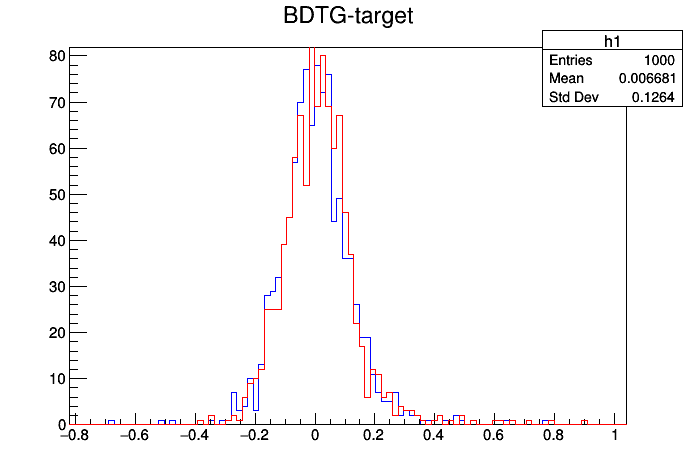

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [9]:
//%jsroot on
outputFile->Close();
auto resultsFile = TFile::Open("TMVA_RegressionOutput.root");
auto resultsTree = (TTree*) resultsFile->Get("dataset/TestTree"); 
// BDTG-AD is the predicted value, target is the true value
auto h1 = new TH1D("h1","BDTG-target",100,1,0);
resultsTree->Draw("BDTG_HU-target >> h1"); 
auto h2 = (TH1*) h1->Clone("h2");
resultsTree->Draw("BDTG_LS-target >> h2"); 
h1->SetLineColor(kBlue); h1->Draw();
h2->SetLineColor(kRed); h2->Draw("SAME");
gPad->Draw();